In [1]:
import numpy as np
import pandas as pd
import os
import datetime

import pyarrow.parquet as pq

import matplotlib.pyplot as plt
import seaborn as sns

from plotnine import *
from mizani.formatters import percent_format, date_format

# Go to settings and set files.maxMemoryForLargeFilesMB to 16384 before running this

file_dir = '/Users/zhicong/Dropbox/DEXs/Data/dex_swaps'

# Data Extraction

We are only able to extract swap data for one pair of token as my device does not have enough RAM to load the full dataset.

In [2]:
data = pd.DataFrame(columns = ['BLOCK_NUMBER','BLOCK_TIMESTAMP','TX_HASH','SENDER','TX_TO','PLATFORM','POOL_NAME','CONTRACT_ADDRESS',
                               'EVENT_NAME','AMOUNT_IN','SYMBOL_IN','AMOUNT_OUT','SYMBOL_OUT'])
parquet_file = pq.ParquetFile(os.path.join(file_dir, "DEXs_swaps_full.gzip"))

# Set tokens that we want to analyze
token1 = "USDC"
token2 = "WETH"

# Read by batch to be able to fit dataframe into memory
for i in parquet_file.iter_batches(batch_size = 1000000):

    # Filter out only tokens we want
    temp = i.to_pandas()
    temp = temp[((temp['SYMBOL_IN'] == token1) & (temp['SYMBOL_OUT'] == token2)) | ((temp['SYMBOL_IN'] == token2) & (temp['SYMBOL_OUT'] == token1))]

    data = pd.concat([data,temp], axis = 0)
    del temp

# Final cleaning
data.reset_index(drop = True, inplace = True)
data['AMOUNT_IN'] = data['AMOUNT_IN'].astype(float)
data['AMOUNT_OUT'] = data['AMOUNT_OUT'].astype(float)
data['BLOCK_TIMESTAMP'] = pd.to_datetime(data['BLOCK_TIMESTAMP'])

# Data Analysis

We first get the swap price of WETH/USDC and clean anomalies from our data.

In [3]:
# Get swap price of WETH/USDC
data['swap_price'] = np.where(data['SYMBOL_IN'] == 'WETH', data['AMOUNT_OUT']/data['AMOUNT_IN'], data['AMOUNT_IN']/data['AMOUNT_OUT'])
data.replace([np.inf, -np.inf], np.nan, inplace = True)
data.dropna(subset = ['swap_price'], how = "all", inplace = True)

# Remove anomalies (simple as removing obsurb values)
data = data[(data['swap_price'] > 100) & (data['swap_price'] < 5000)]
data = data[~data['PLATFORM'].isin(['curve'])]
data.reset_index(inplace = True, drop = True)

# Add a column called 'volume' that indicates the volume of swap in USDC
data['volume'] = np.where(data['SYMBOL_IN'] == 'WETH', data['AMOUNT_OUT'], data['AMOUNT_IN'])

data

,BLOCK_NUMBER,BLOCK_TIMESTAMP,TX_HASH,SENDER,TX_TO,PLATFORM,POOL_NAME,CONTRACT_ADDRESS,EVENT_NAME,AMOUNT_IN,SYMBOL_IN,AMOUNT_OUT,SYMBOL_OUT,swap_price,volume
0,17244711,2023-05-12 14:25:47,0x09536b4a391886d4be909cffea3ce156aade96de09f0...,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,uniswap-v3,USDC-WETH 500 10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Swap,113907.573860,USDC,64.054072,WETH,1778.303398,113907.573860
1,17244711,2023-05-12 14:25:47,0xd18e70fa4d6e6bda6b8d1e4fa04b6cee7b6c3d429307...,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xdf31685465ddf564c111f3ddc3fc9043d9eb8552,uniswap-v3,USDC-WETH 500 10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Swap,4.000000,WETH,7104.979083,USDC,1776.244771,7104.979083
2,17244711,2023-05-12 14:25:47,0xeb896c0bce00527e71102ef43480a851eafacb92e86e...,0x9507c04b10486547584c37bcbd931b2a4fee9a41,0x9507c04b10486547584c37bcbd931b2a4fee9a41,uniswap-v3,USDC-WETH 500 10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Swap,66.305009,WETH,117791.972275,USDC,1776.516948,117791.972275
3,17244710,2023-05-12 14:25:35,0x2dbbc5778bc6db4bc9c92d9ddf2a5998667c86737763...,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,uniswap-v3,USDC-WETH 500 10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Swap,500.000000,USDC,0.281206,WETH,1778.053952,500.000000
4,17244710,2023-05-12 14:25:35,0xd9c448a5888047ed94e0898f9cb6b003845bcd319037...,0xdef1c0ded9bec7f1a1670819833240f027b25eff,0xdef1c0ded9bec7f1a1670819833240f027b25eff,uniswap-v3,USDC-WETH 500 10,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640,Swap,1000.000000,USDC,0.562414,WETH,1778.050681,1000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11288602,10045107,2020-05-11 13:08:48,0x840bb5ab0a779b4f733443651ac54dabe24e243c3606...,0x57ead0a9f49fafdd2447f615b036f3c316af5171,0x57ead0a9f49fafdd2447f615b036f3c316af5171,uniswap-v2,USDC-WETH,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,Swap,0.001000,WETH,0.204870,USDC,204.870000,0.204870
11288603,10014418,2020-05-06 18:51:12,0x735cf98e86a5df67b6a837ae50de1d7a589d9f6baaf0...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x12ede161c702d1494612d19f05992f43aa6a26fb,uniswap-v2,USDC-WETH,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,Swap,0.000689,USDC,0.000003,WETH,201.910785,0.000689
11288604,10013764,2020-05-06 16:24:55,0x43b6bfd06dde0814fe9c1b63ce98ec4c67c72d96169d...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x8688a84fcfd84d8f78020d0fc0b35987cc58911f,uniswap-v2,USDC-WETH,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,Swap,0.000005,WETH,0.001000,USDC,200.678676,0.001000
11288605,10008585,2020-05-05 21:12:35,0x697b7aaca56a80a8d3a2f560ed7f1ecb97c22b2edd6e...,0xf164fc0ec4e93095b804a4795bbe1e041497b92a,0x11e4857bb9993a50c685a79afad4e6f65d518dda,uniswap-v2,USDC-WETH,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,Swap,0.000049,WETH,0.010000,USDC,202.919065,0.010000


It will be interesting to see the number of trades and volume of trading activities in these exchanges.

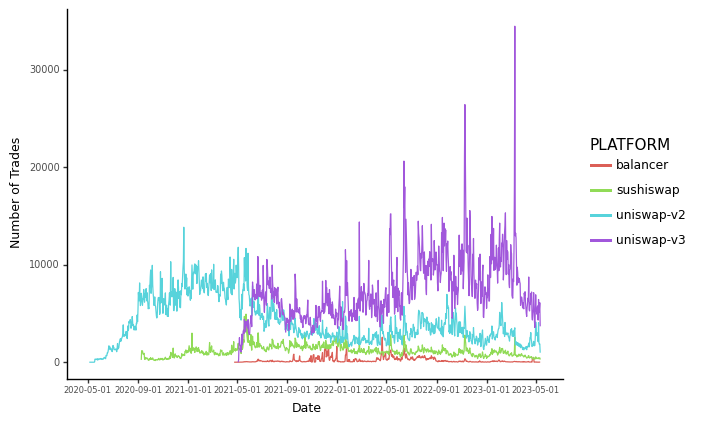

In [4]:
trading_activies = data[['BLOCK_TIMESTAMP','PLATFORM','volume']].copy()
trading_activies['date'] = trading_activies['BLOCK_TIMESTAMP'].dt.date
trading_activies['date'] = pd.to_datetime(trading_activies['date'])
trading_activies.drop(columns = ['BLOCK_TIMESTAMP'], inplace = True)

fig = (
ggplot(trading_activies.groupby(['PLATFORM','date']).size().reset_index(name = 'count'), aes(x = 'date')) +
    geom_line(aes(y = 'count',  color = 'PLATFORM')) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Number of Trades')
)

#fig.save('./Visualizations/WETH-USDC_Number_Trades_Day.png')
print(fig)

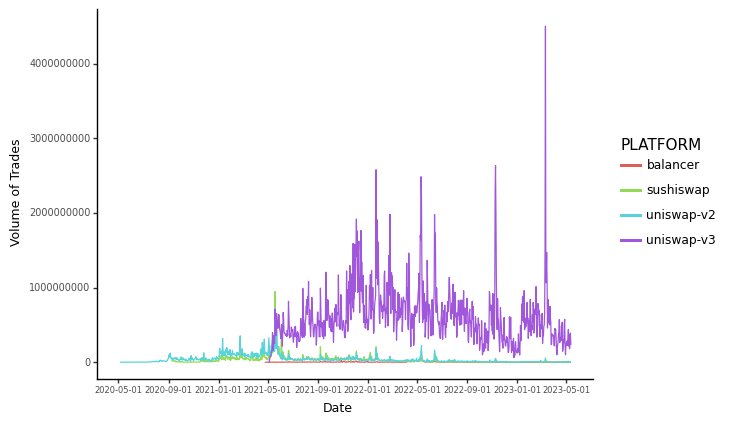

In [5]:
fig = (
ggplot(trading_activies.groupby(['PLATFORM','date'])['volume'].sum().reset_index(), aes(x = 'date')) +
    geom_line(aes(y = 'volume',  color = 'PLATFORM')) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Volume of Trades')
)

#fig.save('./Visualizations/WETH-USDC_Volume_Trades_Day.png')
print(fig)

Would be interesting to see by month.

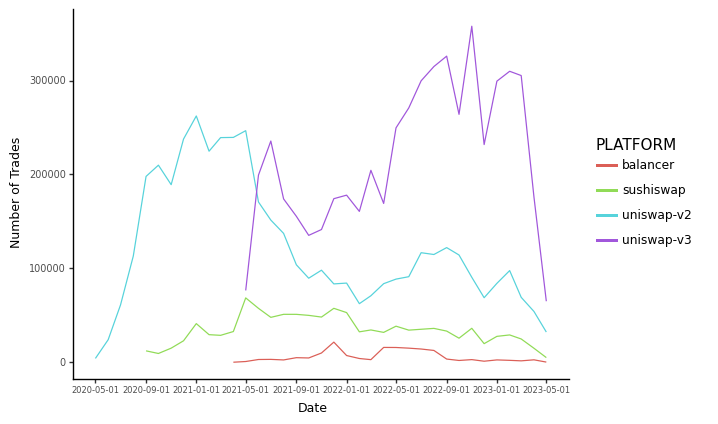

In [6]:
trading_activies_month = trading_activies.copy()
trading_activies_month['year'] = trading_activies_month['date'].dt.year
trading_activies_month['month'] = trading_activies_month['date'].dt.month
trading_activies_month['day'] = 1
trading_activies_month['date'] = pd.to_datetime(trading_activies_month[['year','month','day']])

fig = (
ggplot(trading_activies_month.groupby(['PLATFORM','date']).size().reset_index(name = 'count'), aes(x = 'date')) +
    geom_line(aes(y = 'count',  color = 'PLATFORM')) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Number of Trades')
)

#fig.save('./Visualizations/WETH-USDC_Number_Trades_Month.png')
print(fig)

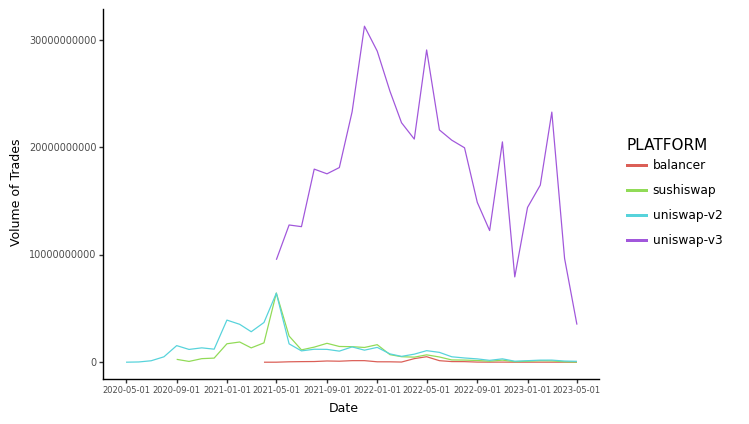

In [7]:
fig = (
ggplot(trading_activies_month.groupby(['PLATFORM','date'])['volume'].sum().reset_index(), aes(x = 'date')) +
    geom_line(aes(y = 'volume',  color = 'PLATFORM')) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Volume of Trades')
)

#fig.save('./Visualizations/WETH-USDC_Volume_Trades_Month.png')
print(fig)

We then aggregate swap price for our token pair by block. We are able to do this by block because each block is atomic (all actions in a block occurs at the same time), therefore, there is no way to send an Ethereum transaction to execute the arbitrage within a block. For swap price differences within a block and an exchange, we take volume weighted average of the prices, this should represent the price you would get in average when your token swap is executed in that block.

Instead, we remove anomalies here. We introduce a rolling 300 blocks 95% confidence interval for the swap price, i.e., each block's swap price is checked whether its price lays within the 95% confidence interval of the previous 300 blocks' swap price. If this is not true, we remove the observation.

In [8]:
# Aggregate by blocks
data_by_block = data.groupby(['BLOCK_NUMBER','BLOCK_TIMESTAMP','PLATFORM','EVENT_NAME']).agg(total_volume = ('volume',np.sum)).reset_index()
data_by_block = data[['BLOCK_NUMBER','BLOCK_TIMESTAMP','PLATFORM','EVENT_NAME','swap_price','volume']].merge(data_by_block, on = ['BLOCK_NUMBER','BLOCK_TIMESTAMP','PLATFORM','EVENT_NAME'], how = 'left')
data_by_block['vwap'] = data_by_block['swap_price']*data_by_block['volume']/data_by_block['total_volume']
data_by_block = data_by_block.groupby(['BLOCK_NUMBER','BLOCK_TIMESTAMP','PLATFORM','EVENT_NAME','total_volume']).agg(vwap = ('vwap',np.sum))
data_by_block.reset_index(inplace = True)

data_by_block = data_by_block.sort_values(by = ['PLATFORM','BLOCK_NUMBER'], ascending = True)
data_by_block.reset_index(drop = True, inplace = True)

# Filter out blocks with anomaly prices
data_by_block['lower_bound'] = (data_by_block.groupby('PLATFORM')['vwap'].rolling(300).mean() - 1.96*data_by_block.groupby('PLATFORM')['vwap'].rolling(300).std()).reset_index(drop = True)
data_by_block['upper_bound'] = (data_by_block.groupby('PLATFORM')['vwap'].rolling(300).mean() + 1.96*data_by_block.groupby('PLATFORM')['vwap'].rolling(300).std()).reset_index(drop = True)
data_by_block = data_by_block[(data_by_block['vwap'] >= data_by_block['lower_bound']) & (data_by_block['vwap'] <= data_by_block['upper_bound'])]
data_by_block.reset_index(drop = True, inplace = True)

data_by_block

,BLOCK_NUMBER,BLOCK_TIMESTAMP,PLATFORM,EVENT_NAME,total_volume,vwap,lower_bound,upper_bound
0,12484404,2021-05-22 13:36:51,balancer,Swap,924.426499,2435.867766,1935.666917,4127.098770
1,12484686,2021-05-22 14:41:50,balancer,Swap,2559.576403,2386.515334,1937.500974,4126.299737
2,12484842,2021-05-22 15:14:26,balancer,Swap,4795.616785,2339.325261,1937.146429,4126.444704
3,12484866,2021-05-22 15:19:28,balancer,Swap,1307.490666,2300.543330,1933.577790,4127.574586
4,12484931,2021-05-22 15:33:05,balancer,Swap,302.207488,2290.349275,1935.783528,4126.499421
...,...,...,...,...,...,...,...,...
5774403,17244706,2023-05-12 14:24:47,uniswap-v3,Swap,196544.641843,1776.719444,1768.472097,1779.393444
5774404,17244707,2023-05-12 14:24:59,uniswap-v3,Swap,2452.506491,1778.073707,1768.529371,1779.404095
5774405,17244708,2023-05-12 14:25:11,uniswap-v3,Swap,7003.000000,1776.286158,1768.566688,1779.410695
5774406,17244710,2023-05-12 14:25:35,uniswap-v3,Swap,1500.000000,1778.051771,1768.596378,1779.436358


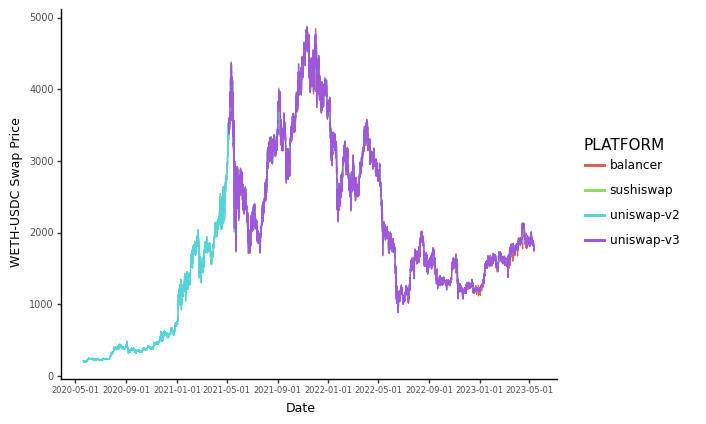

In [9]:
fig = (
ggplot(data_by_block[['BLOCK_TIMESTAMP','PLATFORM','vwap']], aes(x = 'BLOCK_TIMESTAMP')) +
    geom_line(aes(y = 'vwap', color = 'PLATFORM')) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'WETH-USDC Swap Price')
)

#fig.save('./Visualizations/WETH-USDC_Swap_Price.png')
print(fig)

# Arbitrage Index

Here, we will compare the prices of the swap between difference exchanges. For a single block, our arbitrage index will represent the largest difference of swap prices between the 4 DEXs.

For swap prices, we choose to fill NA values backwards. We are able to do this because in DEXs, the swap price of the liqudity pool will not change until a swap occurs, this means that the swap price can be executed in any blocks before that block (but effective price can actually change when liquidity is added or removed from the pool, therefore we are making an assumption here that all our trades are made in spot price).

In [10]:
# This code piece is if we only take swaps from sushiswap and uniswap for comparison
#price_by_DEX = data_by_block[['BLOCK_NUMBER','BLOCK_TIMESTAMP','PLATFORM','vwap','total_volume']].pivot(index = ['BLOCK_NUMBER','BLOCK_TIMESTAMP'], 
#                                                                                                        columns = 'PLATFORM', 
#                                                                                                        values = ['vwap','total_volume'])
#price_by_DEX = price_by_DEX.apply(lambda series: series.loc[series.first_valid_index():].bfill())
#price_by_DEX.columns = ['_'.join(col) for col in price_by_DEX.columns]

#price_by_DEX['price_diff'] = abs(price_by_DEX['vwap_uniswap-v2'] - price_by_DEX['vwap_sushiswap'])
#price_by_DEX.dropna(subset = ['price_diff'], inplace = True)

#price_by_DEX

In [10]:
price_by_DEX = data_by_block[['BLOCK_NUMBER','BLOCK_TIMESTAMP','PLATFORM','vwap','total_volume']].pivot(index = ['BLOCK_NUMBER','BLOCK_TIMESTAMP'], 
                                                                                                        columns = 'PLATFORM', 
                                                                                                        values = ['vwap','total_volume'])
price_by_DEX = price_by_DEX.apply(lambda series: series.loc[series.first_valid_index():].bfill())
price_by_DEX.columns = ['_'.join(col) for col in price_by_DEX.columns]

# Get maximum of absolute price differences and maximum of possible arbitrage profit (price_diff * volume)
price_by_DEX['vwap_balancer-sushiswap'] = abs(price_by_DEX['vwap_balancer'] - price_by_DEX['vwap_sushiswap'])
price_by_DEX['arbitrage_profit_balancer-sushiswap'] = price_by_DEX['vwap_balancer-sushiswap']*price_by_DEX[['total_volume_balancer','total_volume_sushiswap']].min(axis = 1)
price_by_DEX['vwap_balancer-uniswapv2'] = abs(price_by_DEX['vwap_balancer'] - price_by_DEX['vwap_uniswap-v2'])
price_by_DEX['arbitrage_profit_balancer-uniswapv2'] = price_by_DEX['vwap_balancer-uniswapv2']*price_by_DEX[['total_volume_balancer','total_volume_uniswap-v2']].min(axis = 1)
price_by_DEX['vwap_balancer-uniswapv3'] = abs(price_by_DEX['vwap_balancer'] - price_by_DEX['vwap_uniswap-v3'])
price_by_DEX['arbitrage_profit_balancer-uniswapv3'] = price_by_DEX['vwap_balancer-uniswapv3']*price_by_DEX[['total_volume_balancer','total_volume_uniswap-v3']].min(axis = 1)
price_by_DEX['vwap_sushiswap-uniswapv2'] = abs(price_by_DEX['vwap_sushiswap'] - price_by_DEX['vwap_uniswap-v2'])
price_by_DEX['arbitrage_profit_sushiswap-uniswapv2'] = price_by_DEX['vwap_sushiswap-uniswapv2']*price_by_DEX[['total_volume_sushiswap','total_volume_uniswap-v2']].min(axis = 1)
price_by_DEX['vwap_sushiswap-uniswapv3'] = abs(price_by_DEX['vwap_sushiswap'] - price_by_DEX['vwap_uniswap-v3'])
price_by_DEX['arbitrage_profit_sushiswap-uniswapv3'] = price_by_DEX['vwap_sushiswap-uniswapv3']*price_by_DEX[['total_volume_sushiswap','total_volume_uniswap-v3']].min(axis = 1)
price_by_DEX['vwap_uniswapv2-uniswapv3'] = abs(price_by_DEX['vwap_uniswap-v2'] - price_by_DEX['vwap_uniswap-v3'])
price_by_DEX['arbitrage_profit_uniswapv2-uniswapv3'] = price_by_DEX['vwap_uniswapv2-uniswapv3']*price_by_DEX[['total_volume_uniswap-v2','total_volume_uniswap-v3']].min(axis = 1)

price_by_DEX['price_diff'] = price_by_DEX[['vwap_balancer-sushiswap', 'vwap_balancer-uniswapv2', 'vwap_balancer-uniswapv3', 
                                           'vwap_sushiswap-uniswapv2', 'vwap_sushiswap-uniswapv3', 'vwap_uniswapv2-uniswapv3']].max(axis = 1)
price_by_DEX['arbitrage_profit'] = price_by_DEX[['arbitrage_profit_balancer-sushiswap', 'arbitrage_profit_balancer-uniswapv2', 'arbitrage_profit_balancer-uniswapv3', 
                                                 'arbitrage_profit_sushiswap-uniswapv2', 'arbitrage_profit_sushiswap-uniswapv3', 'arbitrage_profit_uniswapv2-uniswapv3']].max(axis = 1)
price_by_DEX.dropna(subset = ['price_diff'], inplace = True)

price_by_DEX

,,vwap_balancer,vwap_sushiswap,vwap_uniswap-v2,vwap_uniswap-v3,total_volume_balancer,total_volume_sushiswap,total_volume_uniswap-v2,total_volume_uniswap-v3,vwap_balancer-sushiswap,arbitrage_profit_balancer-sushiswap,...,vwap_balancer-uniswapv3,arbitrage_profit_balancer-uniswapv3,vwap_sushiswap-uniswapv2,arbitrage_profit_sushiswap-uniswapv2,vwap_sushiswap-uniswapv3,arbitrage_profit_sushiswap-uniswapv3,vwap_uniswapv2-uniswapv3,arbitrage_profit_uniswapv2-uniswapv3,price_diff,arbitrage_profit
BLOCK_NUMBER,BLOCK_TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
10831410,2020-09-10 02:53:52,NaN,368.204064,367.246813,NaN,NaN,352077.50804,27453.665537,NaN,NaN,NaN,...,NaN,NaN,0.957251,26280.059196,NaN,NaN,NaN,NaN,0.957251,26280.059196
10831411,2020-09-10 02:53:53,NaN,369.341599,368.400842,NaN,NaN,800.00000,1668.607768,NaN,NaN,NaN,...,NaN,NaN,0.940758,752.606344,NaN,NaN,NaN,NaN,0.940758,752.606344
10831412,2020-09-10 02:53:57,NaN,369.341599,368.913218,NaN,NaN,800.00000,5939.529637,NaN,NaN,NaN,...,NaN,NaN,0.428382,342.705379,NaN,NaN,NaN,NaN,0.428382,342.705379
10831414,2020-09-10 02:54:12,NaN,369.341599,366.870000,NaN,NaN,800.00000,0.036687,NaN,NaN,NaN,...,NaN,NaN,2.471599,0.090676,NaN,NaN,NaN,NaN,2.471599,0.090676
10831416,2020-09-10 02:54:24,NaN,369.341599,369.168079,NaN,NaN,800.00000,3000.000000,NaN,NaN,NaN,...,NaN,NaN,0.173521,138.816503,NaN,NaN,NaN,NaN,0.173521,138.816503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17244699,2023-05-12 14:23:23,NaN,NaN,1784.373348,1778.940388,NaN,NaN,1000.000000,10684.926859,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.432960,5432.959647,5.432960,5432.959647
17244701,2023-05-12 14:23:47,NaN,NaN,1773.740850,1779.138848,NaN,NaN,35.474817,79960.952970,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.397998,191.492990,5.397998,191.492990
17244704,2023-05-12 14:24:23,NaN,NaN,1773.736600,1777.595147,NaN,NaN,35.474732,146872.892470,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.858547,136.880907,3.858547,136.880907


In [11]:
# Add date
price_by_DEX['date'] = price_by_DEX.index.get_level_values('BLOCK_TIMESTAMP').date
price_by_DEX['date'] = pd.to_datetime(price_by_DEX['date'])

# Add time of day
price_by_DEX['time'] = price_by_DEX.index.get_level_values('BLOCK_TIMESTAMP').time
price_by_DEX['time'] = pd.to_datetime(datetime.date.today().strftime("%Y-%m-%d") + ' ' + price_by_DEX['time'].astype(str))

price_by_DEX

,,vwap_balancer,vwap_sushiswap,vwap_uniswap-v2,vwap_uniswap-v3,total_volume_balancer,total_volume_sushiswap,total_volume_uniswap-v2,total_volume_uniswap-v3,vwap_balancer-sushiswap,arbitrage_profit_balancer-sushiswap,...,vwap_sushiswap-uniswapv2,arbitrage_profit_sushiswap-uniswapv2,vwap_sushiswap-uniswapv3,arbitrage_profit_sushiswap-uniswapv3,vwap_uniswapv2-uniswapv3,arbitrage_profit_uniswapv2-uniswapv3,price_diff,arbitrage_profit,date,time
BLOCK_NUMBER,BLOCK_TIMESTAMP,,,,,,,,,,,,,,,,,,,,,
10831410,2020-09-10 02:53:52,NaN,368.204064,367.246813,NaN,NaN,352077.50804,27453.665537,NaN,NaN,NaN,...,0.957251,26280.059196,NaN,NaN,NaN,NaN,0.957251,26280.059196,2020-09-10,2023-10-03 02:53:52
10831411,2020-09-10 02:53:53,NaN,369.341599,368.400842,NaN,NaN,800.00000,1668.607768,NaN,NaN,NaN,...,0.940758,752.606344,NaN,NaN,NaN,NaN,0.940758,752.606344,2020-09-10,2023-10-03 02:53:53
10831412,2020-09-10 02:53:57,NaN,369.341599,368.913218,NaN,NaN,800.00000,5939.529637,NaN,NaN,NaN,...,0.428382,342.705379,NaN,NaN,NaN,NaN,0.428382,342.705379,2020-09-10,2023-10-03 02:53:57
10831414,2020-09-10 02:54:12,NaN,369.341599,366.870000,NaN,NaN,800.00000,0.036687,NaN,NaN,NaN,...,2.471599,0.090676,NaN,NaN,NaN,NaN,2.471599,0.090676,2020-09-10,2023-10-03 02:54:12
10831416,2020-09-10 02:54:24,NaN,369.341599,369.168079,NaN,NaN,800.00000,3000.000000,NaN,NaN,NaN,...,0.173521,138.816503,NaN,NaN,NaN,NaN,0.173521,138.816503,2020-09-10,2023-10-03 02:54:24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17244699,2023-05-12 14:23:23,NaN,NaN,1784.373348,1778.940388,NaN,NaN,1000.000000,10684.926859,NaN,NaN,...,NaN,NaN,NaN,NaN,5.432960,5432.959647,5.432960,5432.959647,2023-05-12,2023-10-03 14:23:23
17244701,2023-05-12 14:23:47,NaN,NaN,1773.740850,1779.138848,NaN,NaN,35.474817,79960.952970,NaN,NaN,...,NaN,NaN,NaN,NaN,5.397998,191.492990,5.397998,191.492990,2023-05-12,2023-10-03 14:23:47
17244704,2023-05-12 14:24:23,NaN,NaN,1773.736600,1777.595147,NaN,NaN,35.474732,146872.892470,NaN,NaN,...,NaN,NaN,NaN,NaN,3.858547,136.880907,3.858547,136.880907,2023-05-12,2023-10-03 14:24:23


### By Date

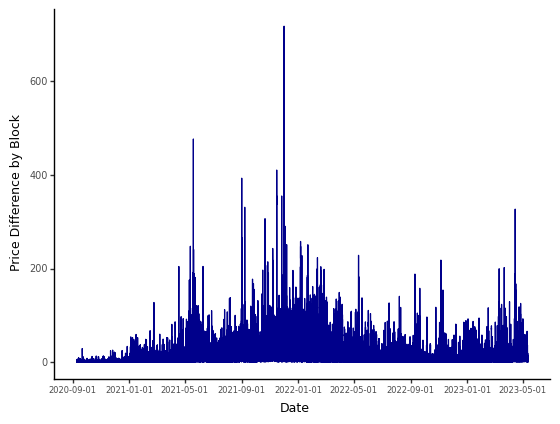

In [12]:
fig = (
ggplot(price_by_DEX[['price_diff']].reset_index(), aes(x = 'BLOCK_TIMESTAMP')) +
    geom_line(aes(y = 'price_diff'), color = 'darkblue') +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Price Difference by Block')
)

#fig.save('./Visualizations/WETH-USDC_Price_Difference.png')
print(fig)

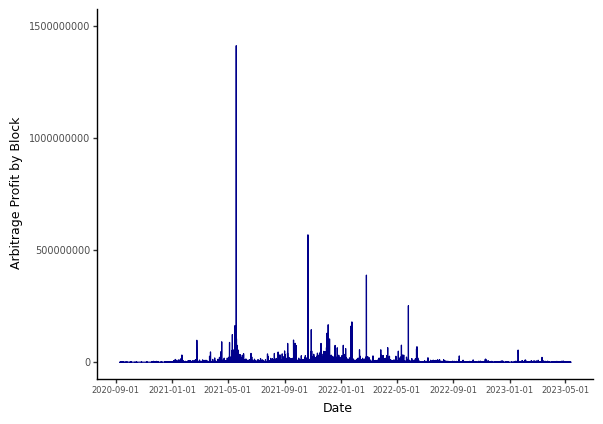

In [13]:
fig = (
ggplot(price_by_DEX[['arbitrage_profit']].reset_index(), aes(x = 'BLOCK_TIMESTAMP')) +
    geom_line(aes(y = 'arbitrage_profit'), color = 'darkblue') +

    scale_y_continuous(breaks = np.arange(0, 2000000000, 500000000),
                       limits = [0, 1500000000]) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Arbitrage Profit by Block')
)

#fig.save('./Visualizations/WETH-USDC_Arbitrage_Profit.png')
print(fig)

The above graph does not give alot of information. We want to average the blocks by day to see the overall trend.

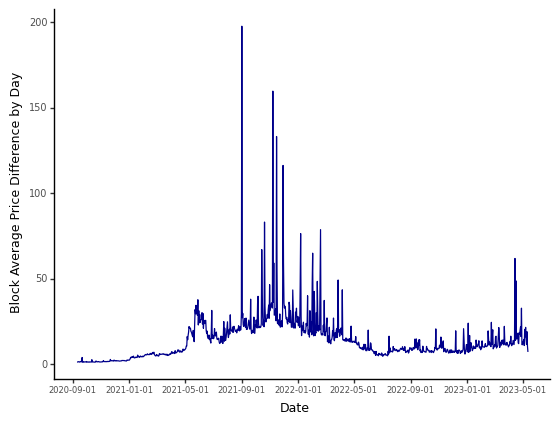

In [14]:
day_average_price_diff = price_by_DEX.groupby(['date'])['price_diff'].mean().reset_index(name = 'day_average_price_diff')

fig = (
ggplot(day_average_price_diff[['date','day_average_price_diff']], aes(x = 'date')) +
    geom_line(aes(y = 'day_average_price_diff'), color = 'darkblue') +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Block Average Price Difference by Day')
)

#fig.save('./Visualizations/WETH-USDC_Day_Average_Price_Difference.png')
print(fig)

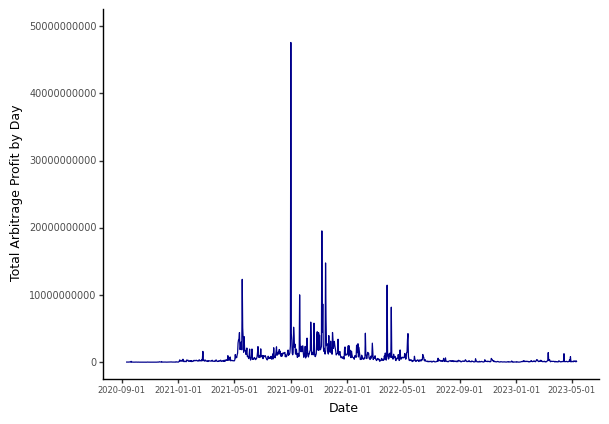

In [15]:
day_average_arbitrage = price_by_DEX.groupby(['date'])['arbitrage_profit'].sum().reset_index(name = 'daily_arbitrage_profit')

fig = (
ggplot(day_average_arbitrage[['date','daily_arbitrage_profit']], aes(x = 'date')) +
    geom_line(aes(y = 'daily_arbitrage_profit'), color = 'darkblue') +

    scale_y_continuous(breaks = np.arange(0, 60000000000, 10000000000),
                       limits = [0, 50000000000]) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Total Arbitrage Profit by Day')
)

#fig.save('./Visualizations/WETH-USDC_Day_Arbitrage_Profit.png')
print(fig)

Try by month? We do see an upward trend.

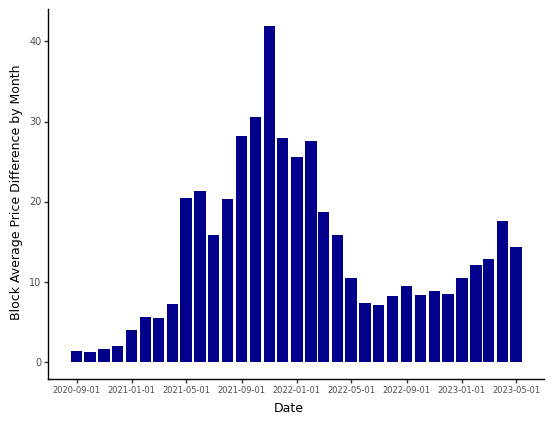

In [16]:
month_average_price_diff = price_by_DEX[['price_diff','date']].copy()
month_average_price_diff['year'] = month_average_price_diff['date'].dt.year
month_average_price_diff['month'] = month_average_price_diff['date'].dt.month
month_average_price_diff['day'] = 1
month_average_price_diff['date'] = pd.to_datetime(month_average_price_diff[['year','month','day']])
month_average_price_diff = month_average_price_diff.groupby('date')['price_diff'].mean().reset_index(name = 'month_average_price_diff')

fig = (
ggplot(month_average_price_diff[['date','month_average_price_diff']], aes(x = 'date')) +
    geom_col(aes(y = 'month_average_price_diff'), fill = 'darkblue') +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Block Average Price Difference by Month')
)

#fig.save('./Visualizations/WETH-USDC_Month_Average_Price_Difference.png')
print(fig)

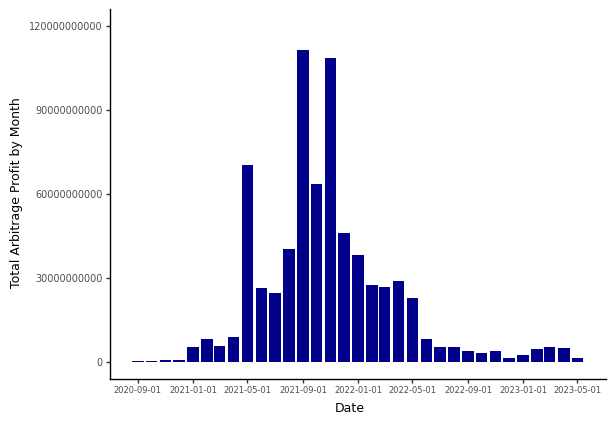

In [17]:
month_average_arbitrage = price_by_DEX[['arbitrage_profit','date']].copy()
month_average_arbitrage['year'] = month_average_arbitrage['date'].dt.year
month_average_arbitrage['month'] = month_average_arbitrage['date'].dt.month
month_average_arbitrage['day'] = 1
month_average_arbitrage['date'] = pd.to_datetime(month_average_arbitrage[['year','month','day']])
month_average_arbitrage = month_average_arbitrage.groupby('date')['arbitrage_profit'].sum().reset_index(name = 'monthly_arbitrage_profit')

fig = (
ggplot(month_average_arbitrage[['date','monthly_arbitrage_profit']], aes(x = 'date')) +
    geom_col(aes(y = 'monthly_arbitrage_profit'), fill = 'darkblue') +

    scale_y_continuous(breaks = np.arange(0, 150000000000, 30000000000),
                       limits = [0, 120000000000]) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Total Arbitrage Profit by Month')
)

#fig.save('./Visualizations/WETH-USDC_Monthly_Arbitrage_Profit.png')
print(fig)

### By Time of Day

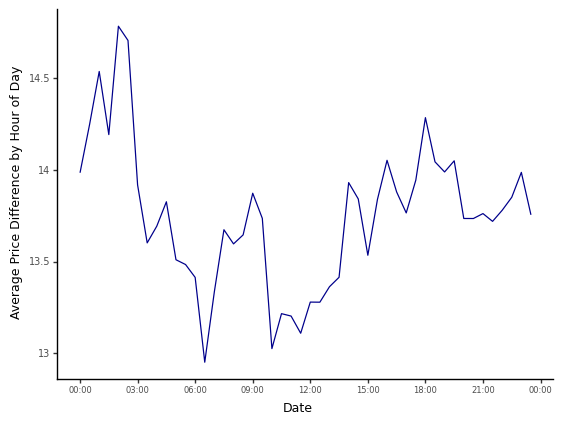

In [18]:
price_by_DEX['hour_min'] = price_by_DEX['time'].dt.floor('30T')

fig = (
ggplot(price_by_DEX.groupby('hour_min')['price_diff'].mean().reset_index(), aes(x = 'hour_min')) +
    geom_line(aes(y = 'price_diff'), color = 'darkblue') + 

    scale_x_datetime(labels = date_format('%H:%M')) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Average Price Difference by Hour of Day')
)

#fig.save('./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour.png')
print(fig)

Now, arbitrage might be resolve by bots that runs 24/7. However, in the past before bots were developed, it is possible that they are executed by humans that will have a work schedule. We might be able to use this to locate the timezone of arbitrageurs.

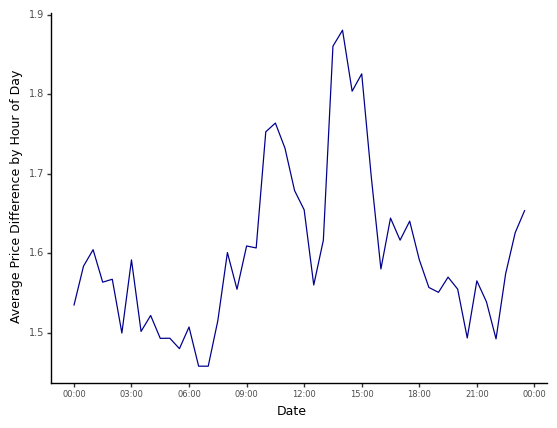

In [19]:
fig = (
ggplot(price_by_DEX[price_by_DEX['date'] < datetime.datetime(2021,1,1)].groupby('hour_min')['price_diff'].mean().reset_index(), aes(x = 'hour_min')) +
    geom_line(aes(y = 'price_diff'), color = 'darkblue') + 

    scale_x_datetime(labels = date_format('%H:%M')) +

    theme_classic() +
    theme(axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Date', y = 'Average Price Difference by Hour of Day')
)

#fig.save('./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour.png')
print(fig)

We want to compare for Uniswap V2 and Sushiswap only.

,date,daily_arbitrage_profit
0,2020-09-10,4128.209324
1,2020-09-11,4320.099306
2,2020-09-12,4577.779224
3,2020-09-13,4922.069830
4,2020-09-14,4483.029297
...,...,...
108,2020-12-27,9661.381751
109,2020-12-28,9331.605505
110,2020-12-29,8756.935054
111,2020-12-30,9288.271771


/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 9 x 4 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour.png


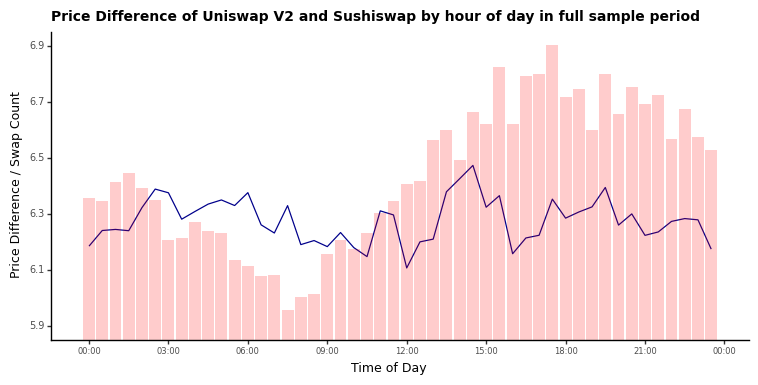

In [21]:
fig = (
ggplot(data = price_by_DEX.groupby('hour_min').agg(price_diff = ('vwap_sushiswap-uniswapv2','mean'), num_of_obs = ('vwap_sushiswap-uniswapv2','count')).reset_index()) +

    # Add lines and barplots
    geom_line(aes(x = 'hour_min', y = 'price_diff'), color = 'darkblue') + 
    geom_col(aes(x = 'hour_min', y = 'num_of_obs/13000'), fill = 'red', alpha = 0.2) +
    
    # Scale axis and fix frame
    scale_x_datetime(labels = date_format('%H:%M')) +
    scale_y_continuous(breaks = np.arange(5.9, 7.1, 0.2)) +
    coord_cartesian(ylim = [5.9,6.9]) +

    # Aesthetics
    theme_classic() +
    theme(figure_size=(9, 4),
          plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Time of Day', y = 'Price Difference / Swap Count',
         title = 'Price Difference of Uniswap V2 and Sushiswap by hour of day in full sample period')
)

fig.save('./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour.png')
print(fig)

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 9 x 4 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour_before_2021.png


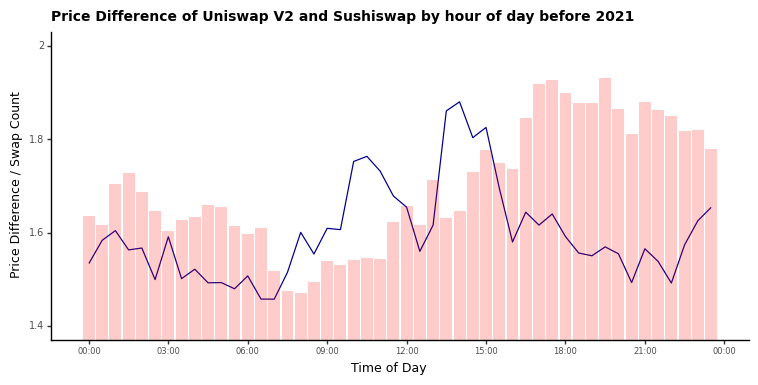

In [22]:
fig = (
ggplot(data = price_by_DEX[price_by_DEX['date'] < datetime.datetime(2021,1,1)].groupby('hour_min').agg(price_diff = ('vwap_sushiswap-uniswapv2','mean'), 
                                                                                                       num_of_obs = ('vwap_sushiswap-uniswapv2','count')).reset_index()) +

    # Add lines and barplots
    geom_line(aes(x = 'hour_min', y = 'price_diff'), color = 'darkblue') + 
    geom_col(aes(x = 'hour_min', y = 'num_of_obs/5000'), fill = 'red', alpha = 0.2) +
    
    # Scale axis and fix frame
    scale_x_datetime(labels = date_format('%H:%M')) +
    scale_y_continuous(breaks = np.arange(1.4, 2.2, 0.2)) +
    coord_cartesian(ylim = [1.4,2]) +

    # Aesthetics
    theme_classic() +
    theme(figure_size=(9, 4),
          plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Time of Day', y = 'Price Difference / Swap Count',
         title = 'Price Difference of Uniswap V2 and Sushiswap by hour of day before 2021')
)

fig.save('./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour_before_2021.png')
print(fig)

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 9 x 4 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour_2021.png


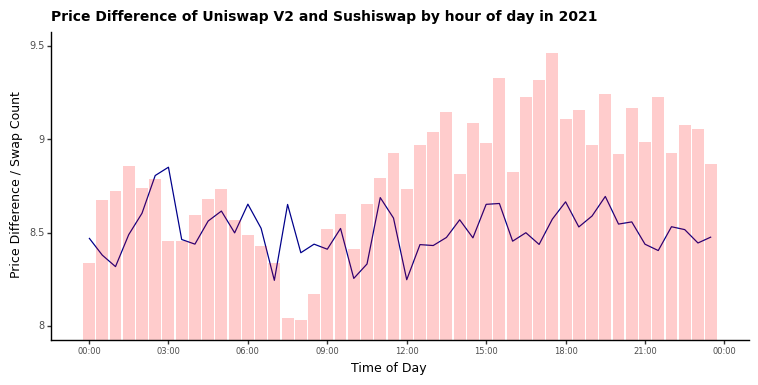

In [23]:
fig = (
ggplot(data = price_by_DEX[(price_by_DEX['date'] >= datetime.datetime(2021,1,1)) &
                           (price_by_DEX['date'] < datetime.datetime(2022,1,1))].groupby('hour_min').agg(price_diff = ('vwap_sushiswap-uniswapv2','mean'), 
                                                                                                         num_of_obs = ('vwap_sushiswap-uniswapv2','count')).reset_index()) +

    # Add lines and barplots
    geom_line(aes(x = 'hour_min', y = 'price_diff'), color = 'darkblue') + 
    geom_col(aes(x = 'hour_min', y = 'num_of_obs/3500'), fill = 'red', alpha = 0.2) +
    
    # Scale axis and fix frame
    scale_x_datetime(labels = date_format('%H:%M')) +
    scale_y_continuous(breaks = np.arange(8, 10, 0.5)) +
    coord_cartesian(ylim = [8,9.5]) +

    # Aesthetics
    theme_classic() +
    theme(figure_size=(9, 4),
          plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Time of Day', y = 'Price Difference / Swap Count',
         title = 'Price Difference of Uniswap V2 and Sushiswap by hour of day in 2021')
)

fig.save('./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour_2021.png')
print(fig)

/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:718: PlotnineWarning: Saving 9 x 4 in image.
/Users/zhicong/python_envs/blockchain_env/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Filename: ./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour_2022.png


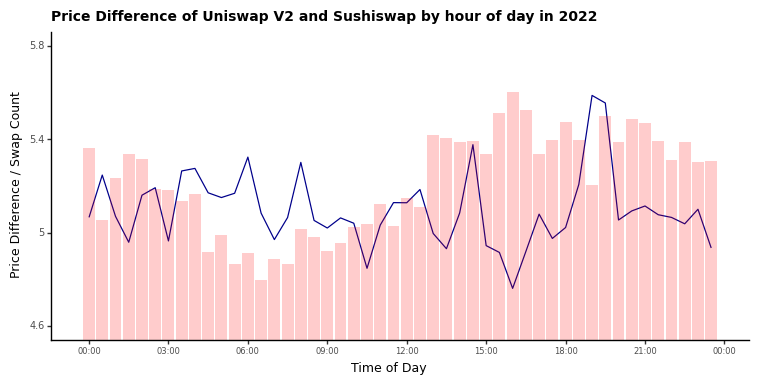

In [24]:
fig = (
ggplot(data = price_by_DEX[(price_by_DEX['date'] >= datetime.datetime(2023,1,1)) &
                           (price_by_DEX['date'] < datetime.datetime(2024,1,1))].groupby('hour_min').agg(price_diff = ('vwap_sushiswap-uniswapv2','mean'), 
                                                                                                         num_of_obs = ('vwap_sushiswap-uniswapv2','count')).reset_index()) +

    # Add lines and barplots
    geom_line(aes(x = 'hour_min', y = 'price_diff'), color = 'darkblue') + 
    geom_col(aes(x = 'hour_min', y = 'num_of_obs/2400'), fill = 'red', alpha = 0.2) +
    
    # Scale axis and fix frame
    scale_x_datetime(labels = date_format('%H:%M')) +
    scale_y_continuous(breaks = np.arange(4.6, 6.2, 0.4)) +
    coord_cartesian(ylim = [4.6,5.8]) +

    # Aesthetics
    theme_classic() +
    theme(figure_size=(9, 4),
          plot_title = element_text(size = 10, face = 'bold', ha = 'left'),
          axis_title_y = element_text(size = 9),
          axis_title_x = element_text(size = 9),
          axis_text_y = element_text(size = 7),
          axis_text_x = element_text(size = 6)) +
    labs(x = 'Time of Day', y = 'Price Difference / Swap Count',
         title = 'Price Difference of Uniswap V2 and Sushiswap by hour of day in 2022')
)

fig.save('./Visualizations/WETH-USDC_Average_Price_Difference_by_Hour_2022.png')
print(fig)